In [1]:
import numpy as np
from qiskit import Aer, execute, BasicAer
from scipy.optimize import minimize 
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister 
import pennylane as qml 
shots=1024
%matplotlib inline 

In [2]:
def Ansatz(num_qubits, reps, param):
    """""
    Create the parametrized circuit using a set of parameters and Ry gates

    ---- Arguments
    num_qubits: (int) Number of qubits (Related to the size of your hamiltonian)
    reps: (int) Depht of your ansatz
    param: (list) Set of angles used in the rotation gates

    ---- Return
    circuit: (QuantumCircuit) Returns a quantum circuit with the gates creating the trial state

    """
    
    circuit=QuantumCircuit(num_qubits) 
    
    for irep in range(reps): 
        for i in range(num_qubits): 
            circuit.ry(param[i+irep*num_qubits],i)
        if irep < reps-1: 
            for j in range(num_qubits-1):
                circuit.cx(j,j+1)
            circuit.cx(num_qubits-1,0)
    circuit.barrier()
    #circuit.measure(range(num_qubits), range(num_qubits))      
    return circuit  

def get_probabilities(counts,shots):  ##########
    prob= {}
    for result,i in counts.items(): 
        prob[result]= i/shots 
    return prob    

def checker(counts): 
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
    return counts

def get_expectation(parameters, reps): #Change it to build a circuit for operator 
    
    expectation={}
    
    strings = ['00','01','10','11'] 

    for i in range(6):

        if i==0:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
            counts= checker(counts)
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g0*(counts['00'] + counts['11'] + counts['01'] + counts['10'] / shots)
        if i==1:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit1=QuantumCircuit(num_qubits)
            circuit1.z(1)
            circuit.compose(circuit1, qubits=[0,1], inplace=True)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
            counts= checker(counts)
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g1*(counts['00'] - counts['11'] + counts['01'] - counts['10'] / shots)
        if i==2:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit2=QuantumCircuit(num_qubits)
            circuit2.z(0)
            circuit.compose(circuit2, qubits=[0,1], inplace=True)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
            counts= checker(counts)
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g2*(counts['00'] - counts['11'] + counts['01'] + counts['10'] / shots)
        if i==3:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit3=QuantumCircuit(num_qubits)
            circuit3.z(1)
            circuit3.z(0)
            circuit.compose(circuit3, qubits=[0,1], inplace=True)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit)
            counts= checker(counts) 
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g3*(counts['00'] - counts['11'] - counts['01'] - counts['10'] / shots)
        if i==4:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit4=QuantumCircuit(num_qubits)
            circuit4.h(1)
            circuit4.sdg(1)
            circuit4.h(1)
            circuit4.h(0)
            circuit4.sdg(0)
            circuit4.h(0)
            circuit.compose(circuit4, qubits=[0,1], inplace=True)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
            counts= checker(counts)
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g4*(counts['00'] + counts['11'] - counts['01'] - counts['10'] / shots)
        if i==5:
            circuit = Ansatz(num_qubits, reps, parameters)
            circuit5=QuantumCircuit(num_qubits)
            circuit5.h(1)
            circuit5.z(1)
            circuit5.h(1)
            circuit5.h(0)
            circuit5.z(0)
            circuit5.h(0)
            circuit.compose(circuit5, qubits=[0,1], inplace=True)
            circuit.measure_all()
            counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
            counts= checker(counts)
            #prob=get_probabilities(counts,shots) 
            expectation[i] = g5*(counts['00'] - counts['11'] - counts['01'] - counts['10'] / shots)

    return  sum(expectation.values())

def execute_VQE(num_qubits, reps,list_coef, shots=shots): #Function that I'll minimize 
    
    backend = BasicAer.get_backend('qasm_simulator')
    
    def execute_circ(parameters, reps=reps):
        return get_expectation(parameters,reps)
    
    return execute_circ

{'00': 1024}


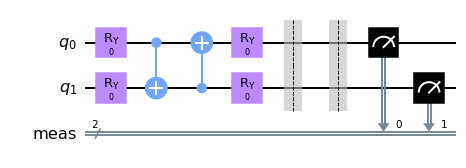

In [11]:
circuit=Ansatz(num_qubits=2, reps=2,param =  [0,0,0,0])
circuit.measure_all()
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(circuit, backend, shots=shots).result().get_counts(circuit)

print(counts)
circuit.draw('mpl') 

In [100]:
#Setting up the Hamiltonian
from qiskit.opflow import X, Z, I, Y

g0 = -0.4804
g1 = +0.3435
g2 = -0.4347
g3 = +0.5716
g4 = +0.0910
g5 = +0.0910 

H_mol = (g0*I^I)+(g1*I^Z)+(g2*Z^I)+(g3*Z^Z)+(g4*Y^Y)+(g5*X^X) 
list_coef=[g0,g1,g2,g3,g4,g5]

In [106]:
num_qubits=2
reps=2
list_coef = list_coef

vqe_run= execute_VQE(num_qubits, reps, list_coef, shots=shots)
res=minimize(vqe_run,np.random.uniform(3, np.pi, 4), method="COBYLA") 

res


     fun: -1140.8128182617188
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 55
  status: 1
 success: True
       x: array([1.80755185, 5.08287546, 4.32492265, 5.21437027])

In [107]:
sol= get_expectation([1.80755185, 5.08287546, 4.32492265, 5.21437027], 2) 

sol

-1121.4409748046876

In [103]:
Ham= np.matrix([[5, 0,0,0], [0,0,-1,0],[0,-1,0,0],[0,0,0,7]])

coeffs, obs_list= qml.utils.decompose_hamiltonian(Ham)

H=qml.Hamiltonian(coeffs,obs_list,simplify=True) 

H

  (-0.5) [Z1]
+ (-0.5) [Z0]
+ (3.0) [I0]
+ (-0.5) [X0 X1]
+ (-0.5) [Y0 Y1]
+ (3.0) [Z0 Z1]


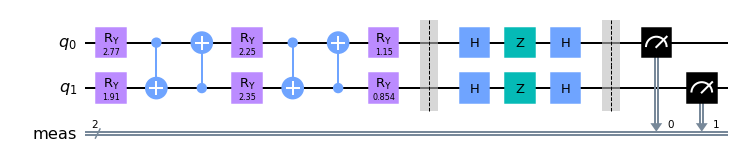

In [110]:
num_qubits=2
reps=3
list_coef = list_coef
#strings = ['000','001','010','011','100','101','110','111']
strings = ['00','01','10','11']

expectation={}

circuit = Ansatz(num_qubits, reps,  np.random.uniform(0, np.pi, 6))
circuit5=QuantumCircuit(num_qubits)
circuit5.h(1)
circuit5.z(1)
circuit5.h(1)
circuit5.h(0)
circuit5.z(0)
circuit5.h(0)
circuit.compose(circuit5, qubits=[0,1], inplace=True)
circuit.measure_all()
counts= execute(circuit, backend, shots=shots).result().get_counts(circuit) 
counts= checker(counts)
prob=get_probabilities(counts,shots) 
expectation[0] = g0*(counts['00'] + counts['11'] - counts['01'] - counts['10'] / shots)

#counts 
total_counts, counts, zz 

circuit.draw('mpl')